In [1]:
%matplotlib inline

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle


In [2]:
# mostly(tm) borrowed from Udacity example given in lessons
# from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('image', img)
        #cv2.waitKey(50)
        
cv2.destroyAllWindows()


In [3]:
## Test the calibration on one of the example chessboards. Very obvious that the calibration has hixed the distortion. 

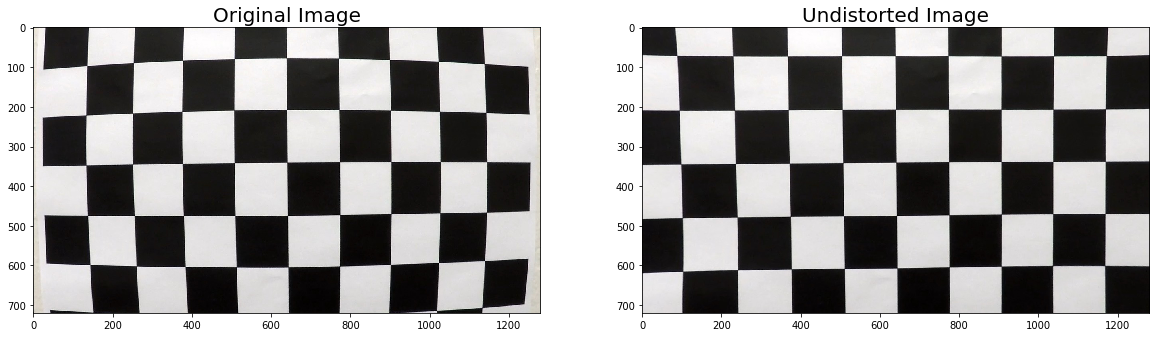

In [4]:
# again, mostly(tm) borrowed from Udacity example given in lessons

# Test undistortion on a chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

## Test on a real image
### Notice that the left bridge barrier seems to be 'steeper' in the undistroted image. Also, the hood of the car at the bottom of the image is different.

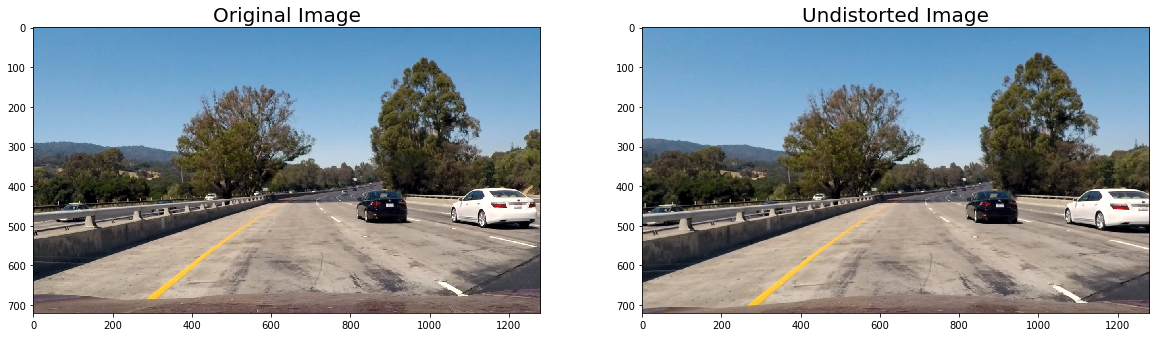

In [5]:
# again, mostly(tm) borrowed from Udacity example given in lessons
#

# Test undistortion on a chessboard image
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix colorspace
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "test_images/test_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
#def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

def combined_thresh(img, sobel_kernel=3, s_thresh=(25, 255), m_thresh=(30, 255), d_thresh=(0.7, 1.3)):
    # Sobel transform the image
    sobelx_img = abs_sobel_thresh(image, orient='x',sobel_kernel=3, thresh=s_thresh)
    sobely_img = abs_sobel_thresh(image, orient='y',sobel_kernel=3, thresh=s_thresh)
    # magnitude transform the image
    mag_img = mag_thresh(image, sobel_kernel=3, thresh=m_thresh)
    # directional gradient with sobel and magnitude 
    dir_img = dir_threshold(image, sobel_kernel=15, thresh=d_thresh)
    #combine them
    combined = np.zeros_like(dir_img)
    combined[((sobelx_img == 1) & (sobely_img == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1
    
    return combined
    

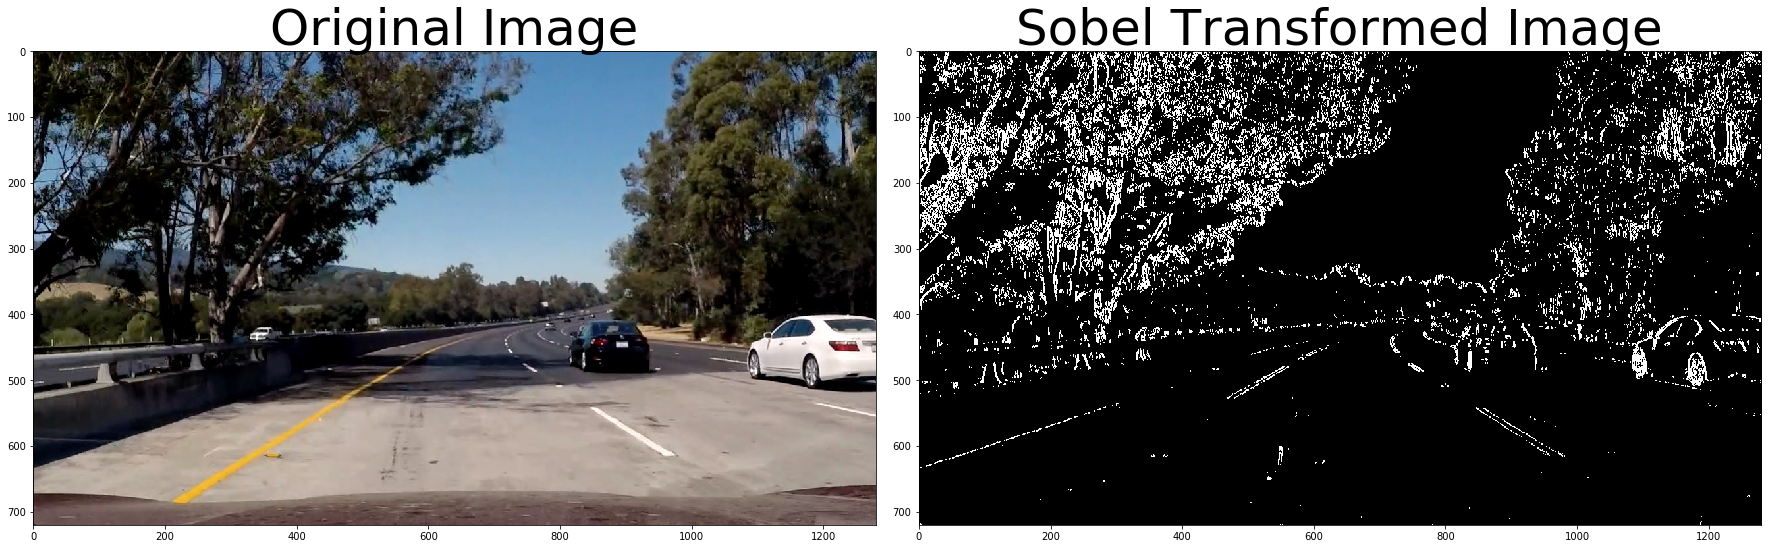

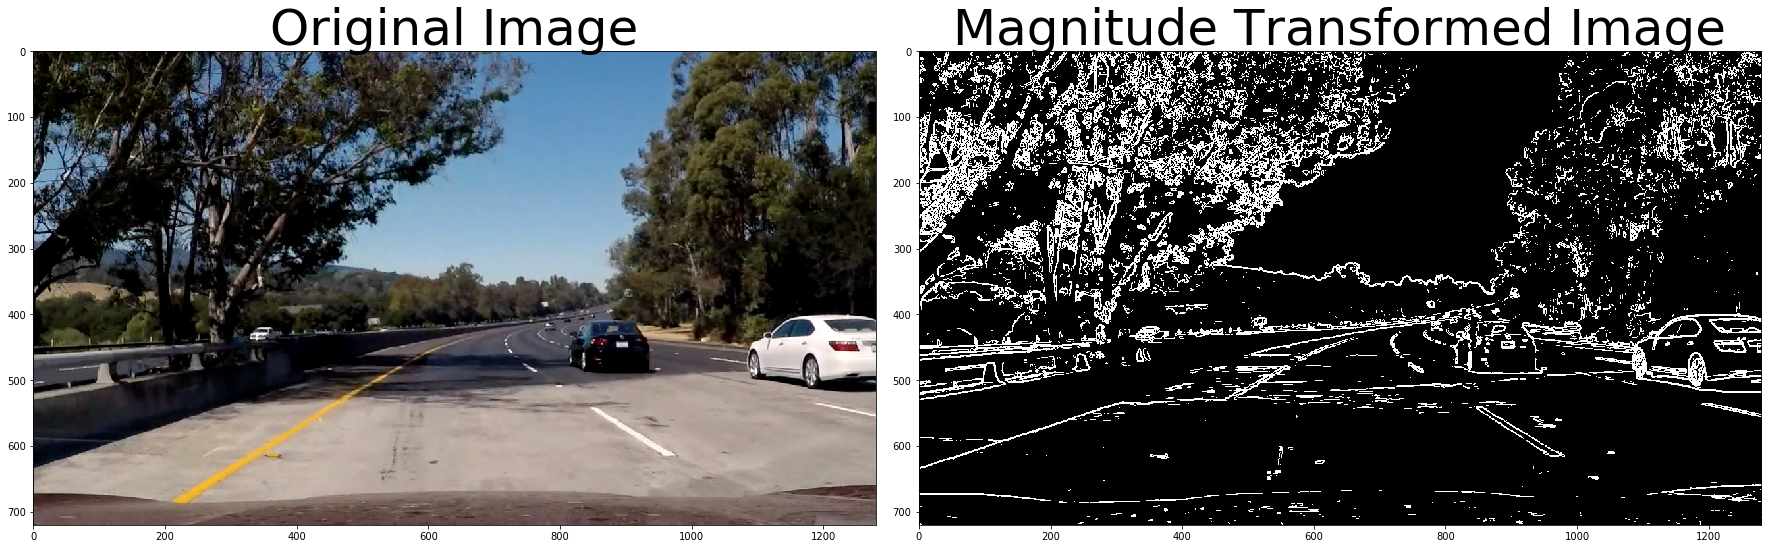

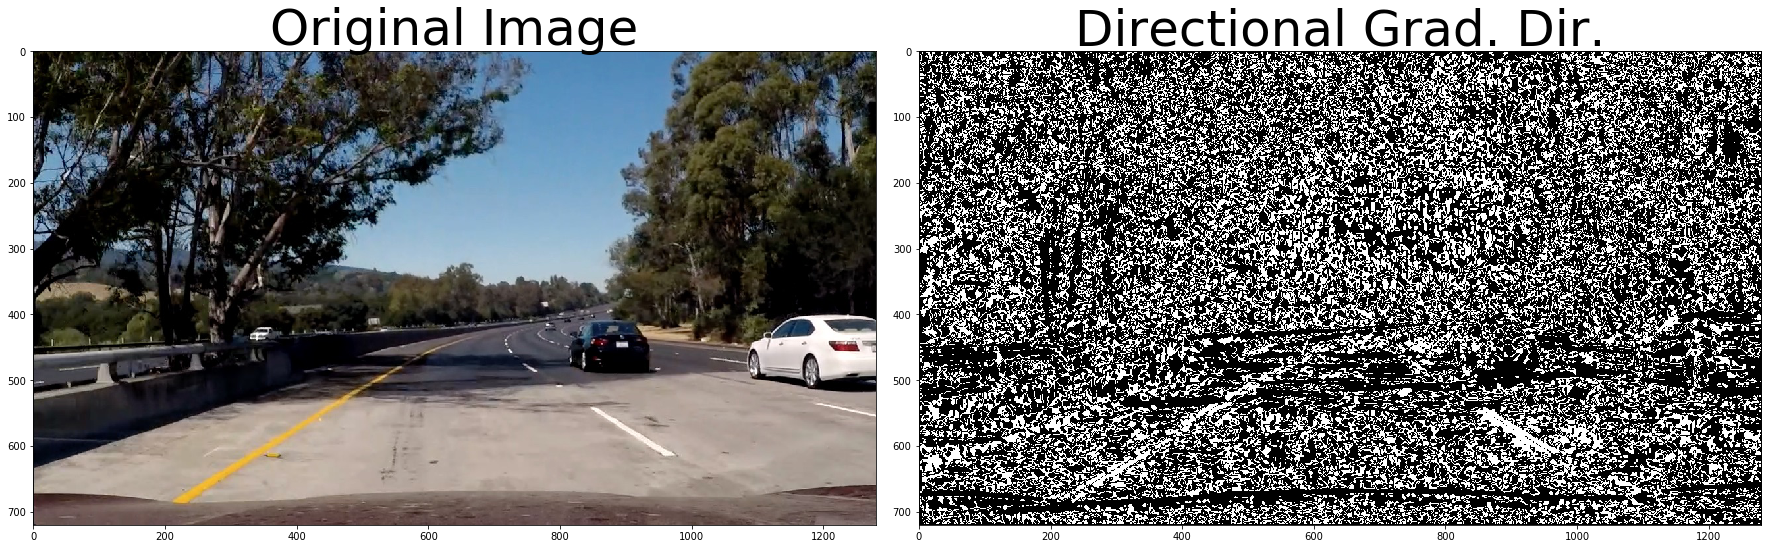

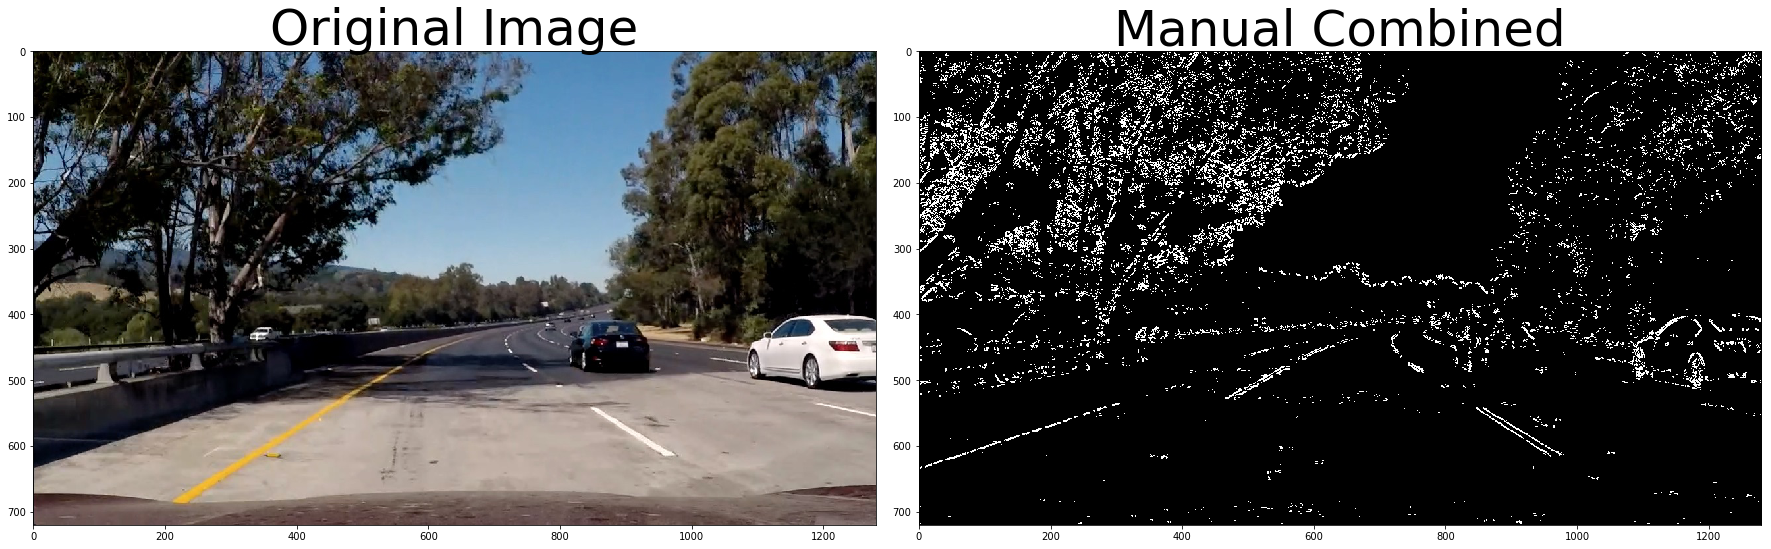

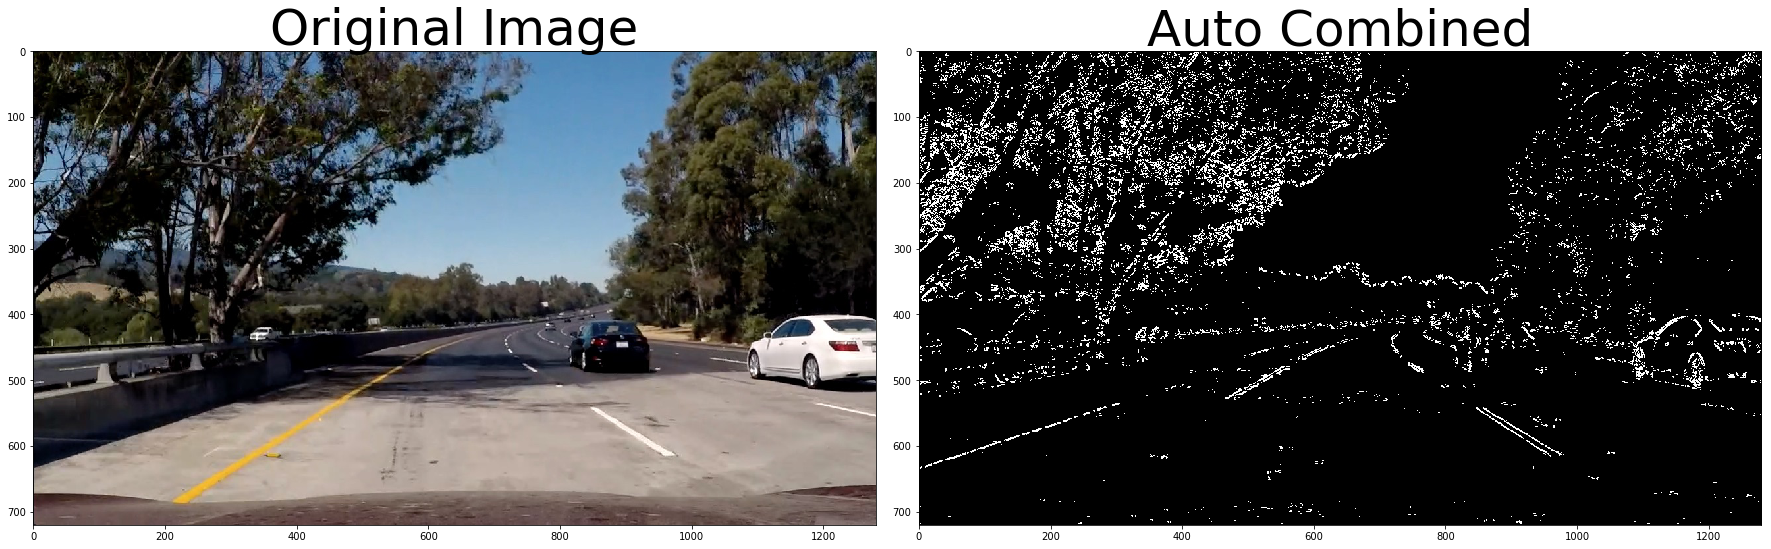

In [7]:
# test on an image
image  = cv2.imread('test_images/test5.jpg')
#image  = cv2.imread('test_images/straight_lines2.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # fix colorspace

# Sobel transform the image
sobelx_img = abs_sobel_thresh(image, orient='x',sobel_kernel=3, thresh=(25, 255))
sobely_img = abs_sobel_thresh(image, orient='y',sobel_kernel=3, thresh=(25, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(sobelx_img, cmap='gray')
ax2.set_title('Sobel Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# magnitude transform the image
mag_img = mag_thresh(image, sobel_kernel=3, thresh=(30, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_img, cmap='gray')
ax2.set_title('Magnitude Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# directional gradient with sobel and magnitude 
dir_img = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_img, cmap='gray')
ax2.set_title('Directional Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#combine them manually
combined = np.zeros_like(dir_img)
combined[((sobelx_img == 1) & (sobely_img == 1)) | ((mag_img == 1) & (dir_img == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Manual Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#combine them magically
combined = combined_thresh(image, sobel_kernel=3, s_thresh=(25, 255), m_thresh=(30, 255), d_thresh=(0.7, 1.3))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Auto Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





### Perspective warping/transforming


In [8]:
def perspective_shift(image, src_corners, dest_corners):
    image_size = (image.shape[1], image.shape[0])
    
    M = cv2.getPerspectiveTransform(src_corners, dest_corners)
    
    image_warped = cv2.warpPerspective(image, M, img_size)

    return image_warped, M

In [9]:
# define our corner locations
src_corners = np.float32([[225,720],[590,450],[690,450],[1025,720]])
dest_corners = np.float32([[275,720],[275,0],[1025,0],[1025,725]])

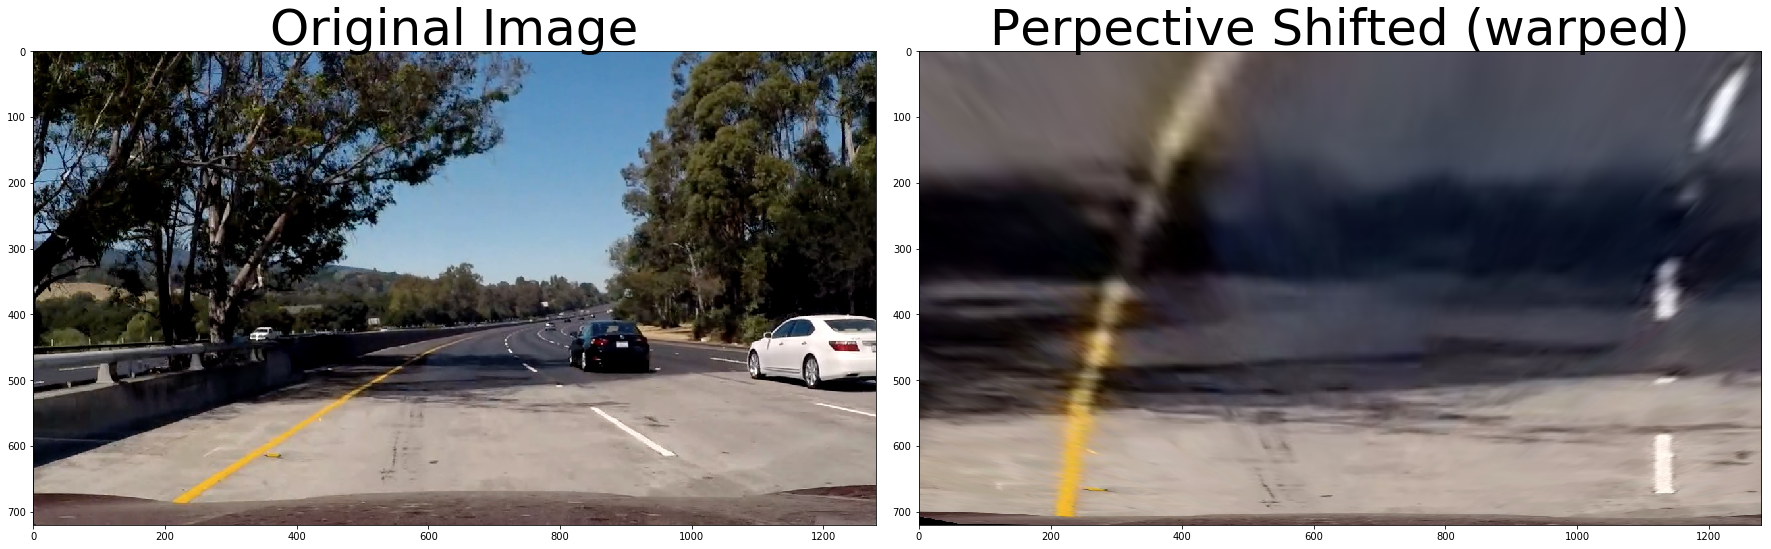

In [10]:
# Show perspective shifted image
warped_image, M = perspective_shift(image, src_corners, dest_corners)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_image)
ax2.set_title('Perpective Shifted (warped)', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Histogram of the perspective image

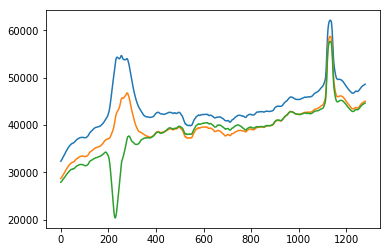

In [11]:
import numpy as np
import matplotlib.pyplot as plt

histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Calculate the radius of the curve


In [12]:
# from 16.37
def calc_curve(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    
    #Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad, right_curverad)

### As per lesson 16 - pretty much borrowed directly then adapted to use the above methods

In [13]:
# from lesson 16.34/35
# 
def draw_lane_lines(original_img, undist, binary_warped, M):
    binary_warped = np.copy(binary_warped)
    
    # Take a histogram of the bottom half of the image
    
    # we're nor re-using the above histogram just so we can grab as-si code from our lesson work
    # in the real world we'd be more efficient
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 65
    # Set minimum number of pixels found to recenter window
    minpix = 75
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### end of big section from 16.35 

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        # from 16.37    
    # Get radius of curvature
    left_curverad, right_curverad = calc_curve(ploty, leftx, lefty, rightx, righty)
    avg_rad_curve = (left_curverad+right_curverad)/2
    
    # Get offset
    lane_center = (right_fitx[ploty.argmax()] + left_fitx[ploty.argmax()])/2 
    abs_middle = 640.0
    offset_px = abs_middle-lane_center
    offset_m = offset_px * 3.7/700
    
    ### from the project pages we get the way to re-draw the image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
  
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    cv2.polylines(color_warp, np.int32(pts_left), False, (255,0,0), thickness=50)
    cv2.polylines(color_warp, np.int32(pts_right), False, (0,0,255), thickness=50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    inv_M = inv_M = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, inv_M, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # overlay some basic telemetry data
    result = cv2.putText(result, ('Radius: ' + str(int(avg_rad_curve)) + '(m)'), 
        (25,50), cv2.FONT_HERSHEY_PLAIN , 2, (255,255,255), 2, lineType=cv2.LINE_AA)
    
    result = cv2.putText(result, ('Offset: %.2fm' % offset_m), 
        (25,75), cv2.FONT_HERSHEY_PLAIN , 2, (255,255,255), 2, lineType=cv2.LINE_AA)

    return (result)

### Process frames (images) from the video

In [14]:
# 
def process_frame(original_img):
    # using the camera calibration we did at the bginning, undistort the image
    undist = cv2.undistort(original_img, mtx, dist, None, mtx)
    
    # get thresholded image
    combined = combined_thresh(undist, sobel_kernel=3, s_thresh=(25, 255), m_thresh=(30, 255), d_thresh=(0.7, 1.3))
    
    # 'warp' or perspective shift the image
    binary_warped, M = perspective_shift(combined, src_corners, dest_corners)
    
    # draw the lines
    lined_image = draw_lane_lines(original_img, undist, binary_warped, M)

    return(lined_image)
    

### process a test image

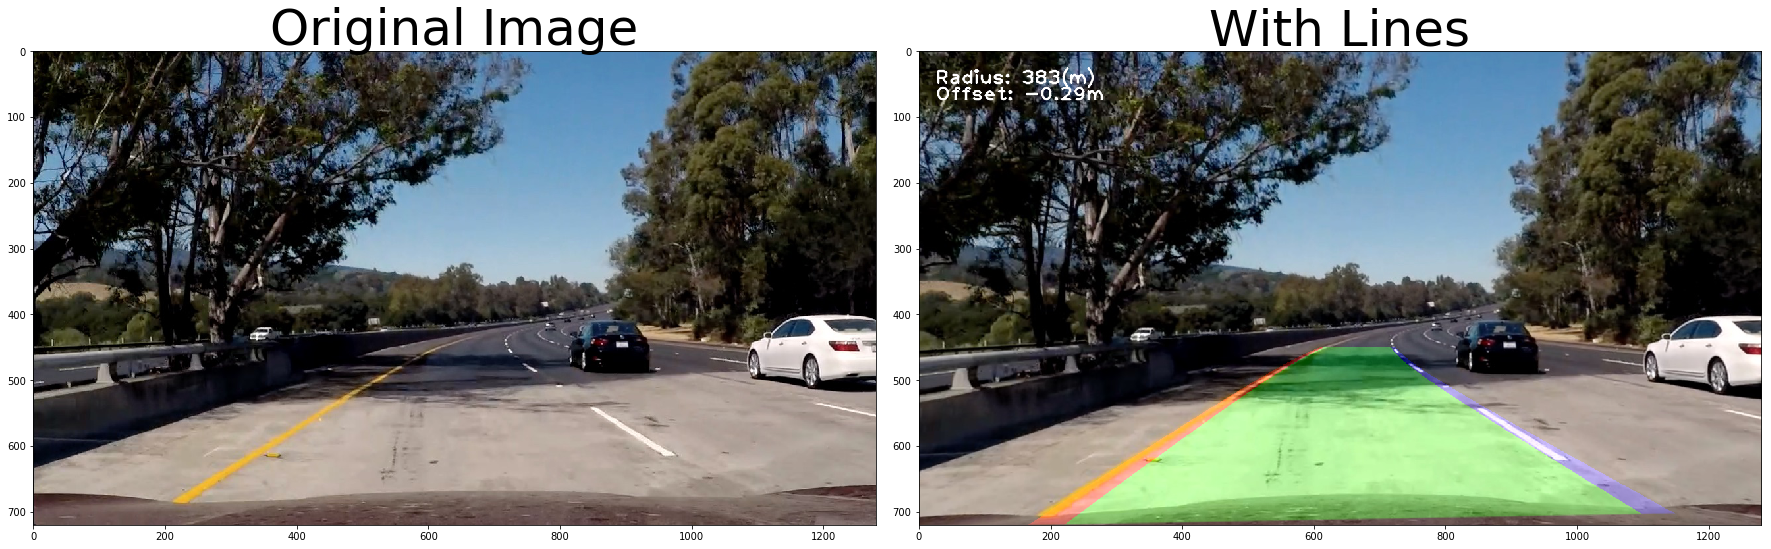

In [15]:
# Show perspective shifted image
lined_image = process_frame(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(lined_image)
ax2.set_title('With Lines', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [17]:
import requests
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(video_output, audio=False)


ImportError: No module named 'requests'